In [ ]:
! pip install tensorflow scikit-learn pandas numpy

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pickle


In [36]:
# Load the dataset
data = pd.read_csv("/content/resampled1_stock_data_with_keywords.csv")  # Update the path to your CSV file
# Split dataset into features (text) and target (sentiment_category)
X = data['text']
y = data['sentiment_category']

# Convert sentiment categories into numeric values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data into training and testing sets (70:30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_len = 100  # You can adjust the max length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [37]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: Positive, Negative, Neutral

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarize the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define batch_size and epochs
batch_size = 8  # or try 8 for more frequent updates
epochs = 15  # or try up to 20 epochs depending on model convergence

print(f"Training with batch_size={batch_size} and epochs={epochs}")

# Train the model with fixed batch_size and epochs
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")


Training with batch_size=8 and epochs=15
Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.6167 - loss: 0.8688 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9940 - loss: 0.0492 - val_accuracy: 0.9832 - val_loss: 0.0401
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9889 - loss: 0.0253 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 1.0000 - loss: 7.4889e-04 - val_accuracy: 1.0000 - val_loss: 7.8194e-04
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 1.0000 - loss: 6.3206e-04 - val_accuracy: 1.0000 - val_loss: 6.0291e-04
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/s

In [39]:
model.save('best_model.h5')


In [40]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved model (Keras .h5 format)
model = load_model('best_model.h5')


# Prepare a list of sample texts for prediction
sample_texts = [
    "INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES",
    "INDEX OPTIONS TRADE 2BANKNIFTY 48100 CESTOP LOSS TAKEN",
    "ALL TARGETS ACHIEVED IN NIFTY TRADE123"
    # Add more sample texts corresponding to stock dates
]

# Tokenize and pad the sample texts
sample_seqs = tokenizer.texts_to_sequences(sample_texts)
sample_pads = pad_sequences(sample_seqs, maxlen=100)

# Predict sentiments for each sample text
predictions = model.predict(sample_pads)

# Get predicted classes and their probabilities
predicted_classes = np.argmax(predictions, axis=1)
predicted_probabilities = np.max(predictions, axis=1)

# Decode the predictions back to original sentiment categories
predicted_sentiments = encoder.inverse_transform(predicted_classes)

# Print the predicted sentiment and prediction confidence for each sample text
for text, sentiment, prob in zip(sample_texts, predicted_sentiments, predicted_probabilities):
    print(f"Text: {text}\nPredicted Sentiment: {sentiment} (Confidence: {prob * 100:.2f}%)\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Text: INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES
Predicted Sentiment: Neutral (Confidence: 99.98%)

Text: INDEX OPTIONS TRADE 2BANKNIFTY 48100 CESTOP LOSS TAKEN
Predicted Sentiment: Negative (Confidence: 99.84%)

Text: ALL TARGETS ACHIEVED IN NIFTY TRADE123
Predicted Sentiment: Positive (Confidence: 93.14%)



In [50]:
import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model (Keras .h5 format)
model = load_model('best_model.h5')

# Define the function to predict stock movement based on sentiment
def predict_stock_movement(sentiment_score):
    if sentiment_score == 2:  # Positive sentiment
        return 1  # Predict "Up"
    elif sentiment_score == 0:  # Negative sentiment
        return -1  # Predict "Down"
    else:
        return 0  # Neutral sentiment

# Function to parse user input into timestamp and message list
def parse_input(input_string):
    lines = input_string.strip().split("\n")
    data = []
    for line in lines:
        timestamp, message = line.split(",", 1)
        data.append({"timestamp": timestamp.strip(), "message": message.strip()})
    return data

# Example of user input (replace this with actual input from the user)
user_input = """
2024-11-21 16:17:03+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 2999 6 MONTHS AT 4999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-22 02:52:59+00:00,Gift nifty green
2024-11-22 03:45:32+00:00,BANKNIFTY 50500 CEAbove  430Sl open TRG 450480
2024-11-22 13:41:02+00:00,INDEX OPTIONS TRADEBANKNIFTY HEDGE TRADEBLASTEDHEDGE TRADE!49900 CE AT 115050300 CE AT 800NET GAINS OF 140 POINTS
2024-11-22 13:51:03+00:00,INDEX OPTIONS TRADENIFTY 23400 CE230 TO 620MASSIVE 390 POINTS AFTER OUR TRADE
2024-11-22 13:56:34+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 3999 6 MONTHS AT 5999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-25 03:45:40+00:00,BANKNIFTY 51800 CEAbove  330Sl open TRG 370400
2024-11-25 06:56:43+00:00,INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES
2024-11-25 08:32:31+00:00,"RISKY TRADERSSELL BANKNIFTY NOV FUTURES AROUND 52050TARGET 51900,51700,51500STOP LOSS 52200"
2024-11-25 11:08:49+00:00,INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES
2024-11-25 13:13:29+00:00,OUR BANKNIFTY HEDGE TRADEGENERATED NET RETURNS OF 200 POINTS
2024-11-25 13:43:39+00:00,"YOU CAN JOIN OUR INDEX OPTIONS SERVICESNIFTY, BANKNIFTY, FINNIFTY AND SENSEX OPTIONS TRADES12 TRADES A DAY WITH CLEAR ENTRY AND EXIT UPDATESCAPITAL REQUIRED 3040KJOINING LINKSPECIAL OPTIONS COMBO OFFERS AVAILABLECONTACT USHAANALYSISTHANK YOU"
2024-11-26 02:36:42+00:00,Gift nifty flat green
2024-11-26 02:37:04+00:00,Nifty future flat
2024-11-26 03:45:42+00:00,BANKNIFTY 52000 CEAbove  380Sl open TRG 400420
2024-11-27 03:45:31+00:00,BANKNIFTY 52400 PEAbove  290Sl open TRG 330350
2024-11-28 03:28:10+00:00,NIFTY
2024-11-28 03:28:10+00:00,BANKNIFTY
2024-11-28 03:46:24+00:00,BANKNIFTY 53200 CEAbove  510Sl open TRG 530550

"""
# Parse the user input
data = parse_input(user_input)

# Tokenizer should be defined or loaded beforehand (assuming you have the 'tokenizer' object)
sample_texts = [entry['message'] for entry in data]
sample_timestamps = [entry['timestamp'] for entry in data]

# Tokenize and pad the sample texts
sample_seqs = tokenizer.texts_to_sequences(sample_texts)
sample_pads = pad_sequences(sample_seqs, maxlen=100)

# Predict sentiments for each sample text
predictions = model.predict(sample_pads)

# Get predicted classes and their probabilities
predicted_classes = np.argmax(predictions, axis=1)
predicted_probabilities = np.max(predictions, axis=1)

# List to store stock movement prediction results
results = []

# Iterate through each text and timestamp to predict stock movement
for timestamp, sentiment, prob, text in zip(sample_timestamps, predicted_classes, predicted_probabilities, sample_texts):
    stock_movement = predict_stock_movement(sentiment)
    results.append({
        'timestamp': pd.to_datetime(timestamp),  # Convert to datetime format
        'message': text,
        'predicted_stock_movement': stock_movement,
        'stock_movement_label': 'Up' if stock_movement == 1 else 'Neutral' if stock_movement == 0 else 'Down',
        'predicted_sentiment': sentiment,
        'confidence': prob
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Plot using Plotly
fig = px.scatter(
    df,
    x='timestamp',  # X-axis is the timestamp
    y='predicted_stock_movement',  # Y-axis is the predicted stock movement (-1, 0, 1)
    color='stock_movement_label',  # Color by stock movement label (Up, Neutral, Down)
    color_discrete_map={'Up': 'green', 'Neutral': 'gray', 'Down': 'red'},  # Custom colors
    labels={'predicted_stock_movement': 'Stock Movement (-1: Down, 0: Neutral, 1: Up)', 'timestamp': 'Date & Time'},
    title='Predicted Stock Movement Based on Sentiment Over Time',
    hover_data=['message', 'stock_movement_label', 'confidence']  # Display the text, sentiment label, and confidence on hover
)

# Show the plot
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


In [72]:
import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model (Keras .h5 format)
model = load_model('best_model.h5')

# Define the function to predict stock movement based on sentiment
def predict_stock_movement(sentiment_score):
    if sentiment_score == 2:  # Positive sentiment
        return 1  # Predict "Up"
    elif sentiment_score == 0:  # Negative sentiment
        return -1  # Predict "Down"
    else:
        return 0  # Neutral sentiment

# Function to parse user input into timestamp and message list
def parse_input(input_string):
    lines = input_string.strip().split("\n")
    data = []
    for line in lines:
        timestamp, message = line.split(",", 1)
        data.append({"timestamp": timestamp.strip(), "message": message.strip()})
    return data

# Example of user input (replace this with actual input from the user)
user_input = """
2024-11-21 16:17:03+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 2999 6 MONTHS AT 4999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-22 02:52:59+00:00,Gift nifty green
2024-11-22 03:45:32+00:00,BANKNIFTY 50500 CEAbove  430Sl open TRG 450480
2024-11-22 13:41:02+00:00,INDEX OPTIONS TRADEBANKNIFTY HEDGE TRADEBLASTEDHEDGE TRADE!49900 CE AT 115050300 CE AT 800NET GAINS OF 140 POINTS
2024-11-22 13:51:03+00:00,INDEX OPTIONS TRADENIFTY 23400 CE230 TO 620MASSIVE 390 POINTS AFTER OUR TRADE
2024-11-22 13:56:34+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 3999 6 MONTHS AT 5999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-25 03:45:40+00:00,BANKNIFTY 51800 CEAbove  330Sl open TRG 370400
2024-11-25 06:56:43+00:00,INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES
2024-11-25 08:32:31+00:00,"RISKY TRADERSSELL BANKNIFTY NOV FUTURES AROUND 52050TARGET 51900,51700,51500STOP LOSS 52200"
2024-11-25 11:08:49+00:00,INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINSALMOST 3 TIMES
2024-11-25 13:13:29+00:00,OUR BANKNIFTY HEDGE TRADEGENERATED NET RETURNS OF 200 POINTS
2024-11-25 13:43:39+00:00,"YOU CAN JOIN OUR INDEX OPTIONS SERVICESNIFTY, BANKNIFTY, FINNIFTY AND SENSEX OPTIONS TRADES12 TRADES A DAY WITH CLEAR ENTRY AND EXIT UPDATESCAPITAL REQUIRED 3040KJOINING LINKSPECIAL OPTIONS COMBO OFFERS AVAILABLECONTACT USHAANALYSISTHANK YOU"
2024-11-26 02:36:42+00:00,Gift nifty flat green
2024-11-26 02:37:04+00:00,Nifty future flat
2024-11-26 03:45:42+00:00,BANKNIFTY 52000 CEAbove  380Sl open TRG 400420
2024-11-27 03:45:31+00:00,BANKNIFTY 52400 PEAbove  290Sl open TRG 330350
2024-11-28 03:28:10+00:00,NIFTY
2024-11-28 03:28:10+00:00,BANKNIFTY
2024-11-28 03:46:24+00:00,BANKNIFTY 53200 CEAbove  510Sl open TRG 530550
"""
# Parse the user input
data = parse_input(user_input)

# Tokenizer should be defined or loaded beforehand (assuming you have the 'tokenizer' object)
sample_texts = [entry['message'] for entry in data]
sample_timestamps = [entry['timestamp'] for entry in data]

# Tokenize and pad the sample texts
sample_seqs = tokenizer.texts_to_sequences(sample_texts)
sample_pads = pad_sequences(sample_seqs, maxlen=100)

# Predict sentiments for each sample text
predictions = model.predict(sample_pads)

# Get predicted classes and their probabilities
predicted_classes = np.argmax(predictions, axis=1)
predicted_probabilities = np.max(predictions, axis=1)

# List to store stock movement prediction results
results = []

# Iterate through each text and timestamp to predict stock movement
for timestamp, sentiment, prob, text in zip(sample_timestamps, predicted_classes, predicted_probabilities, sample_texts):
    stock_movement = predict_stock_movement(sentiment)
    results.append({
        'timestamp': pd.to_datetime(timestamp),  # Convert to datetime format
        'message': text,
        'predicted_stock_movement': stock_movement,
        'stock_movement_label': 'Up' if stock_movement == 1 else 'Neutral' if stock_movement == 0 else 'Down',
        'predicted_sentiment': sentiment,
        'confidence': f"{prob * 100:.2f}%"  # Convert to percentage and format to 2 decimal places
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Plot using Plotly for the scatter plot
fig = px.scatter(
    df,
    x='timestamp',  # X-axis is the timestamp
    y='predicted_stock_movement',  # Y-axis is the predicted stock movement (-1, 0, 1)
    color='stock_movement_label',  # Color by stock movement label (Up, Neutral, Down)
    color_discrete_map={'Up': 'green', 'Neutral': 'gray', 'Down': 'red'},  # Custom colors
    labels={'predicted_stock_movement': 'Stock Movement (-1: Down, 0: Neutral, 1: Up)', 'timestamp': 'Date & Time'},
    title='Predicted Stock Movement Based on Sentiment Over Time',
    hover_data=['message', 'stock_movement_label', 'confidence']  # Display the text, sentiment label, and confidence on hover
)

# Show the plot
fig.show()

# Plot Pie Chart for Sentiment Analysis with explicit legend
sentiment_counts = df['predicted_sentiment'].value_counts()

# Create mappings for sentiment labels
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

fig_pie = px.pie(
    names=[sentiment_labels[sentiment] for sentiment in sentiment_counts.index],  # Map sentiment classes to labels
    values=sentiment_counts.values,
    title="Sentiment Analysis Distribution",
    labels={'predicted_sentiment': 'Sentiment'},
    color=sentiment_counts.index,
    color_discrete_map={0: 'red', 1: 'gray', 2: 'green'}  # Same mapping
)

fig_pie.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


In [74]:
import plotly.graph_objects as go
import pandas as pd
import yfinance as yf

# Assuming df contains 'predicted_stock_movement' and 'date' columns
# Map predicted stock movement (-1, 0, 1) to labels
movement_map = {1: 'Up', 0: 'Neutral', -1: 'Down'}
df['stock_movement_label'] = df['predicted_stock_movement'].map(movement_map)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the stock symbol (Nifty 50 index as an example)
stock_symbol = '^NSEI'

# Get the start and end dates for fetching stock data
start_date = df['date'].min()
end_date = df['date'].max()

# Fetch stock data from Yahoo Finance for the given symbol and date range
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Ensure the 'Close' column is 1-dimensional by converting it to a Series if necessary
closing_prices = stock_data['Close'].squeeze()  # .squeeze() converts to a 1D array if needed

# Define the color mapping for sentiment-based stock movement
color_map = {'Up': 'green', 'Neutral': 'gray', 'Down': 'red'}

# Create a Plotly figure with dual y-axes
fig = go.Figure()

# Plot the predicted stock movement (sentiment-based) as markers (no lines connecting the points)
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['predicted_stock_movement'],
    mode='markers',  # Only markers, no lines connecting the points
    name='Predicted Stock Movement',
    marker=dict(
        color=df['stock_movement_label'].map(color_map),  # Apply color based on sentiment label
        size=8
    ),
    yaxis='y1'  # y-axis for predicted stock movement
))

# Plot the actual stock price (Nifty 50 closing prices) as a line chart
fig.add_trace(go.Scatter(
    x=closing_prices.index,
    y=closing_prices,
    mode='lines',  # Stock price plot will still be a line
    name='Stock Price',
    line=dict(color='blue'),
    yaxis='y2'  # y-axis for stock price
))

# Update layout to have dual y-axes
fig.update_layout(
    title=f'{stock_symbol} Stock Price vs Predicted Stock Movement Based on Sentiment',
    xaxis=dict(
        title='Date',  # X-axis title
    ),
    yaxis=dict(
        title='Predicted Stock Movement (-1: Down, 0: Neutral, 1: Up)',  # Left y-axis title
        side='left',
        range=[-1.5, 1.5]  # Set the range for stock movement axis
    ),
    yaxis2=dict(
        title='Stock Price',  # Right y-axis title
        side='right',
        overlaying='y',  # This allows the stock price line to overlay the left y-axis
        showgrid=False  # Hide grid for the second axis
    ),
    legend=dict(
        x=0.1,
        y=0.9,
        traceorder='normal',
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="white",
        bordercolor="black",
        borderwidth=2
    ),
)

# Show the plot
fig.show()


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


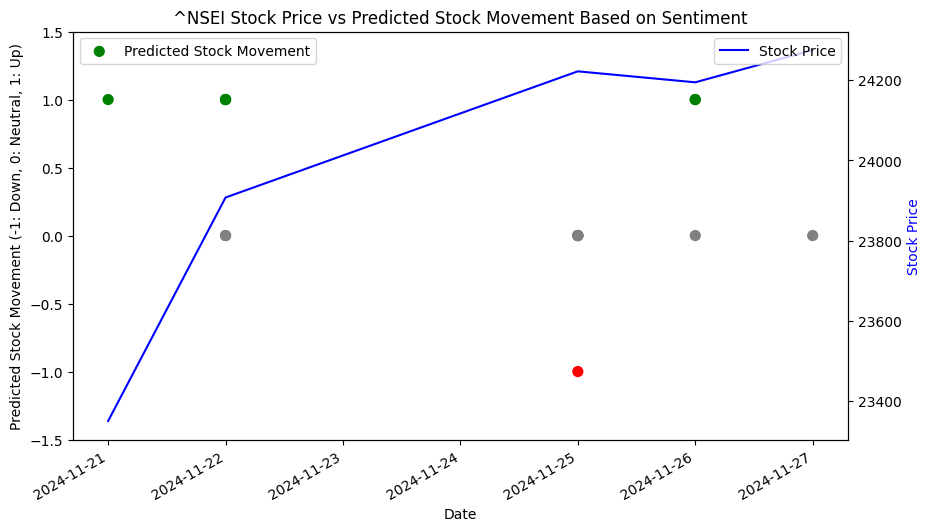

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Assuming df contains 'predicted_stock_movement' and 'date' columns
# Map predicted stock movement (-1, 0, 1) to labels
movement_map = {1: 'Up', 0: 'Neutral', -1: 'Down'}
df['stock_movement_label'] = df['predicted_stock_movement'].map(movement_map)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the stock symbol (Nifty 50 index as an example)
stock_symbol = '^NSEI'

# Get the start and end dates for fetching stock data
start_date = df['date'].min()
end_date = df['date'].max()

# Fetch stock data from Yahoo Finance for the given symbol and date range
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Ensure the 'Close' column is 1-dimensional by converting it to a Series if necessary
closing_prices = stock_data['Close'].squeeze()  # .squeeze() converts to a 1D array if needed

# Plot using Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the predicted stock movement (sentiment-based) as markers (no lines connecting the points)
ax1.scatter(df['date'], df['predicted_stock_movement'], color=df['stock_movement_label'].map({'Up': 'green', 'Neutral': 'gray', 'Down': 'red'}), label='Predicted Stock Movement', s=50)

# Create a second y-axis for the stock prices
ax2 = ax1.twinx()

# Plot the actual stock price (Nifty 50 closing prices) as a line chart
ax2.plot(closing_prices.index, closing_prices, color='blue', label='Stock Price')

# Adding titles and labels
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Stock Movement (-1: Down, 0: Neutral, 1: Up)', color='black')
ax2.set_ylabel('Stock Price', color='blue')

# Set date format for x-axis
fig.autofmt_xdate()

# Set the range for the predicted stock movement axis
ax1.set_ylim(-1.5, 1.5)

# Adding a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding a title
plt.title(f'{stock_symbol} Stock Price vs Predicted Stock Movement Based on Sentiment')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import f1_score, precision_score, accuracy_score

# Load the saved model
model = load_model('best1_model.h5')

# Define function to predict stock movement
def predict_stock_movement(sentiment_score):
    if sentiment_score == 2:  # Positive sentiment
        return 1  # Predict "Up"
    elif sentiment_score == 0:  # Negative sentiment
        return -1  # Predict "Down"
    else:
        return 0  # Neutral sentiment

# Function to parse user input
def parse_input(input_string):
    lines = input_string.strip().split("\n")
    data = []
    for line in lines:
        timestamp, message = line.split(",", 1)
        data.append({"timestamp": timestamp.strip(), "message": message.strip()})
    return data

# Example input
user_input = """
2024-11-21 16:17:03+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 2999 6 MONTHS AT 4999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-22 02:52:59+00:00,Gift nifty green
2024-11-22 03:45:32+00:00,BANKNIFTY 50500 CEAbove  430Sl open TRG 450480
2024-11-22 13:41:02+00:00,INDEX OPTIONS TRADEBANKNIFTY HEDGE TRADEBLASTEDHEDGE TRADE!49900 CE AT 115050300 CE AT 800NET GAINS OF 140 POINTS
2024-11-22 13:51:03+00:00,INDEX OPTIONS TRADENIFTY 23400 CE230 TO 620MASSIVE 390 POINTS AFTER OUR TRADE
2024-11-22 13:56:34+00:00,"SPECIAL OFFERS FOR INDEX OPTIONS SERVICES MONTHLY SERVICE AT 1999 3 MONTHS AT 3999 6 MONTHS AT 5999SERVICES  NIFTY, BANKNIFTY, SENSEX, MIDCPNIFTY, BANKEX AND FINNIFTY OPTIONSDAILY 12 TRADES WITH ENTRY AND EXIT UPDATESJOINING LINKTHANK YOU"
2024-11-25 03:45:40+00:00,BANKNIFTY 51800 CEAbove  330Sl open TRG 370400
2024-11-25 06:56:43+00:00,INDEX OPTIONS TRADENIFTY NOV 24000 CE135 TO 370MASSIVE 235 POINTS GAINS ALMOST 3 TIMES
2024-11-25 08:32:31+00:00,"RISKY TRADERSSELL BANKNIFTY NOV FUTURES AROUND 52050TARGET 51900,51700,51500STOP LOSS 52200"
2024-11-25 13:13:29+00:00,OUR BANKNIFTY HEDGE TRADEGENERATED NET RETURNS OF 200 POINTS
2024-11-25 13:43:39+00:00,"YOU CAN JOIN OUR INDEX OPTIONS SERVICESNIFTY, BANKNIFTY, FINNIFTY AND SENSEX OPTIONS TRADES12 TRADES A DAY WITH CLEAR ENTRY AND EXIT UPDATESCAPITAL REQUIRED 3040KJOINING LINKSPECIAL OPTIONS COMBO OFFERS AVAILABLECONTACT USHAANALYSISTHANK YOU"
2024-11-26 02:36:42+00:00,Gift nifty flat green
2024-11-26 02:37:04+00:00,Nifty future flat
2024-11-26 03:45:42+00:00,BANKNIFTY 52000 CEAbove  380Sl open TRG 400420
2024-11-27 03:45:31+00:00,BANKNIFTY 52400 PEAbove  290Sl open TRG 330350
2024-11-28 03:28:10+00:00,NIFTY
2024-11-28 03:28:10+00:00,BANKNIFTY
2024-11-28 03:46:24+00:00,BANKNIFTY 53200 CEAbove  510Sl open TRG 530550
"""

# Parse the user input
data = parse_input(user_input)

# Prepare data for predictions
sample_texts = [entry['message'] for entry in data]
sample_timestamps = [entry['timestamp'] for entry in data]

# Tokenize and pad texts
# Note: Ensure `tokenizer` is defined or loaded
sample_seqs = tokenizer.texts_to_sequences(sample_texts)
sample_pads = pad_sequences(sample_seqs, maxlen=100)

# Predict sentiments
predictions = model.predict(sample_pads)
predicted_classes = np.argmax(predictions, axis=1)
predicted_probabilities = np.max(predictions, axis=1)

# Prepare results
results = []
for timestamp, sentiment, prob, text in zip(sample_timestamps, predicted_classes, predicted_probabilities, sample_texts):
    stock_movement = predict_stock_movement(sentiment)
    results.append({
        'timestamp': pd.to_datetime(timestamp),
        'message': text,
        'predicted_stock_movement': stock_movement,
        'stock_movement_label': 'Up' if stock_movement == 1 else 'Neutral' if stock_movement == 0 else 'Down',
        'predicted_sentiment': sentiment,
        'confidence': f"{prob * 100:.2f}%"  # Confidence as percentage
    })

# Create DataFrame
df = pd.DataFrame(results)

# Scatter Plot: Predicted Stock Movement
fig_scatter = px.scatter(
    df,
    x='timestamp',
    y='predicted_stock_movement',
    color='stock_movement_label',
    color_discrete_map={'Up': 'green', 'Neutral': 'gray', 'Down': 'red'},
    labels={'predicted_stock_movement': 'Stock Movement (-1: Down, 0: Neutral, 1: Up)', 'timestamp': 'Date & Time'},
    title='Predicted Stock Movement Based on Sentiment Over Time',
    hover_data=['message', 'confidence']
)
fig_scatter.show()

# Pie Chart: Sentiment Distribution
sentiment_counts = df['predicted_sentiment'].value_counts()
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
fig_pie = px.pie(
    names=[sentiment_labels[s] for s in sentiment_counts.index],
    values=sentiment_counts.values,
    title="Sentiment Analysis Distribution",
    color_discrete_map={0: 'red', 1: 'gray', 2: 'green'}
)
fig_pie.show()

# Fetch Stock Prices
df['date'] = df['timestamp'].dt.date
stock_symbol = '^NSEI'
start_date = df['timestamp'].min()
end_date = df['timestamp'].max()
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
closing_prices = stock_data['Close'].squeeze()

# Matplotlib Plot: Predicted Stock Movement vs Stock Price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for predicted stock movement
movement_map = {1: 'Up', 0: 'Neutral', -1: 'Down'}
df['stock_movement_label'] = df['predicted_stock_movement'].map(movement_map)
colors = df['stock_movement_label'].map({'Up': 'green', 'Neutral': 'gray', 'Down': 'red'})
ax1.scatter(df['date'], df['predicted_stock_movement'], c=colors, label='Predicted Stock Movement', s=50)

# Line plot for stock prices
ax2 = ax1.twinx()
ax2.plot(closing_prices.index, closing_prices, color='blue', label='Stock Price')

# Set axis labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Stock Movement (-1: Down, 0: Neutral, 1: Up)', color='black')
ax2.set_ylabel('Stock Price', color='blue')
plt.title(f'{stock_symbol} Stock Price vs Predicted Stock Movement')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Format x-axis
fig.autofmt_xdate()

plt.show()

# Calculate Actual Stock Movement
def calculate_actual_stock_movement(stock_data):
    movements = []
    for i in range(1, len(stock_data)):
        if stock_data[i] > stock_data[i-1]:
            movements.append(1)  # Up
        elif stock_data[i] < stock_data[i-1]:
            movements.append(-1)  # Down
        else:
            movements.append(0)  # Neutral
    return movements

# Get actual stock movements from the stock data
actual_stock_movements = calculate_actual_stock_movement(closing_prices)

# Make sure the lengths match between predicted and actual movements
df['predicted_stock_movement'] = df['predicted_stock_movement'].iloc[:len(actual_stock_movements)]

# Ensure we compare only valid data points
valid_data_points = df.dropna(subset=['predicted_stock_movement'])

# Calculate F1 Score and Precision
f1 = f1_score(valid_data_points['predicted_stock_movement'], actual_stock_movements[:len(valid_data_points)], average='weighted')
precision = precision_score(valid_data_points['predicted_stock_movement'], actual_stock_movements[:len(valid_data_points)], average='weighted')

# Print the metrics
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")

# Optionally, you can also compute accuracy
accuracy = accuracy_score(valid_data_points['predicted_stock_movement'], actual_stock_movements[:len(valid_data_points)])
print(f"Accuracy: {accuracy:.2f}")
